<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/HealthComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visión por ordenador en salud

## Instalamos el código y los requerimientos.

In [ ]:
!git clone https://github.com/kevinash/ai-in-sports

Cloning into 'ai-in-sports'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 1343 (delta 21), reused 31 (delta 11), pack-reused 1297
Receiving objects: 100% (1343/1343), 509.97 MiB | 41.75 MiB/s, done.
Resolving deltas: 100% (115/115), done.
Checking out files: 100% (1179/1179), done.


In [ ]:
!pip install -r ./ai-in-sports/requirements.txt

     |████████████████████████████████| 245kB 8.9MB/s 


In [ ]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=b3fde8f6302bbe380b04225894786dfc99a9c60e406a59624b2a49dff93ff0c3
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


# IA e ilusiones ópticas

Los resultados en la identificación de determinadas características por la IA y el cerebro humano son sorprendentemente similares, incluida la percepción de ilusiones ópticas. 

La pareidolia es un fenómeno bien conocido: la mayoría de nosotros veremos un rostro en este dibujo. Nuestra tendencia a ver formas familiares e incluso expresiones faciales a menudo requiere solo unos pocos trazos de lápiz. 

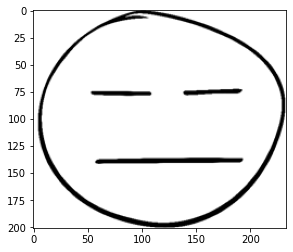

[[ 49 106 143  71]]


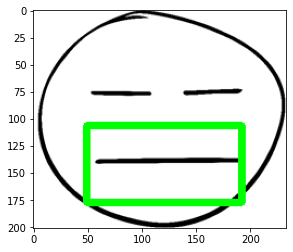

In [ ]:
import cv2
import matplotlib.pyplot as plt
import wget

image = cv2.imread('./ai-in-sports/media/face.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_smile.xml')
features = cascade.detectMultiScale(image)
print(features)
for (x, y, w, h) in features:
    img = image.copy()
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 6)
    plt.imshow(img)
    plt.show()

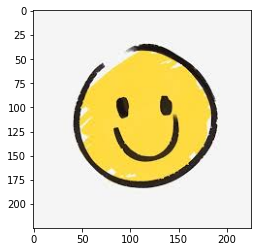

[[ 73  84  79  40]
 [ 74 123  88  44]
 [ 67 155  88  44]]


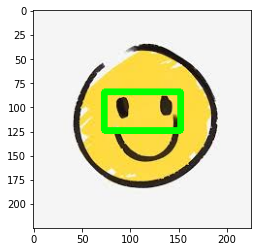

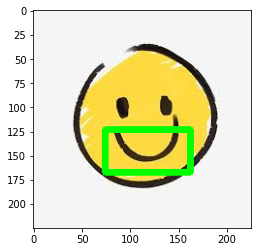

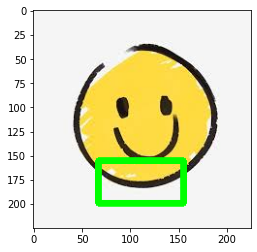

In [ ]:
image = cv2.imread('sonrisa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_smile.xml')
features = cascade.detectMultiScale(image)
print(features)
for (x, y, w, h) in features:
    img = image.copy()
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 6)
    plt.imshow(img)
    plt.show()

Si aplicamos métodos de machine learning para detectar características (como una sonrisa en una figura, que contiene tres trazos rectos y un círculo)po demos obtener los mismos resultados que el cerebro humano. Aunque la cara no sonría el clasificador me dice donde debería estar la sonridsa. El método que utilizo aquí es bien conocido por el reconocimiento facial. Se llama clasificador Haar Cascade y está incluido en OpenCV.

# Modelos

## Clasificación

['surfing', 'tennis']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


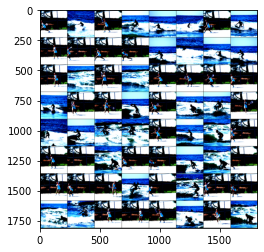

In [ ]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data.sampler import SubsetRandomSampler

f = './ai-in-sports/data/activities'

def load(f, size = .2):
    
    t = transforms.Compose([transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize(mean = [0.485, 0.456, 0.406], 
        std = [0.229, 0.224, 0.225])])
        
    train = datasets.ImageFolder(f, transform=t)
    test = datasets.ImageFolder(f, transform=t)
    n = len(train)
    indices = list(range(n))
    split = int(np.floor(size * n))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train,sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load(f, .2)
print(trainloader.dataset.classes)
images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)
plt.imshow(grid.permute(1,2,0))

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:

features = model.fc.in_features
model.fc = nn.Linear(features, len(labels))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_model(epochs=3):
    total_loss = 0
    train_losses, test_losses = [], []
    i = 0
    for epoch in range(epochs):
        for inputs, labels in trainloader:
            i += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(total_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {total_loss:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
    #plt.plot(train_losses, label='Training loss')
    #plt.plot(test_losses, label='Validation loss')
    #plt.legend(frameon=False)
    #plt.show()
    return model

model = train_model(epochs=3)
torch.save(model, 'activity_classifier_model.pth')

Epoch 1/3.. Train loss: 4.477.. Test loss: 4.357.. Test accuracy: 0.000
Epoch 1/3.. Train loss: 8.730.. Test loss: 3.972.. Test accuracy: 0.000
Epoch 1/3.. Train loss: 12.612.. Test loss: 3.458.. Test accuracy: 0.000
Epoch 2/3.. Train loss: 15.921.. Test loss: 2.831.. Test accuracy: 0.550
Epoch 2/3.. Train loss: 18.530.. Test loss: 2.146.. Test accuracy: 0.775
Epoch 2/3.. Train loss: 20.530.. Test loss: 1.505.. Test accuracy: 0.875
Epoch 3/3.. Train loss: 21.800.. Test loss: 0.979.. Test accuracy: 0.975
Epoch 3/3.. Train loss: 22.640.. Test loss: 0.618.. Test accuracy: 1.000
Epoch 3/3.. Train loss: 23.115.. Test loss: 0.400.. Test accuracy: 1.000


1
0
0
1
0


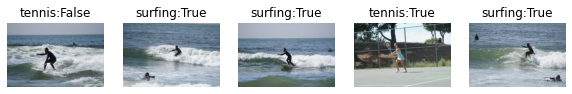

In [ ]:
data_dir = 'ai-in-sports/data/activities/'
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('activity_classifier_model.pth')
model.eval()

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels, classes

from torch.autograd import Variable

to_pil = transforms.ToPILImage()
images, labels, classes = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    print(index)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

## Detección de puntos clave

In [ ]:
import torch
from torchvision import models

kprcnn = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
kprcnn.eval()

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=Tr

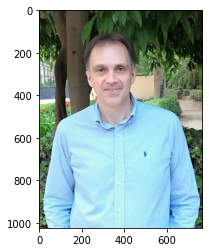

In [20]:
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

#img = Image.open('./ai-in-sports/media/surfer.jpg')
img = Image.open('Foto_perfil_jfvr.jpg')
plt.imshow(img)
plt.show()

In [21]:
import torchvision.transforms as T

def normalize(img):
    normalize_t = T.Compose([T.Resize(256),
                     T.CenterCrop(224),
                     T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
    return normalize_t(img).unsqueeze(0)



img_tensor = normalize(img)
detection = kprcnn(img_tensor)[0]
detection

{'boxes': tensor([[  1.0212,   0.0000,  77.3513, 135.0808],
         [204.6143, 124.6849, 224.0000, 185.5821],
         [123.6420,  69.5486, 134.0747, 110.8014],
         [114.5159,  68.8862, 134.7388, 114.3300],
         [147.3448,   0.0000, 222.5366,  85.4078],
         [ 86.0210,  66.5968, 132.0927, 121.5198],
         [100.9004,  26.7787, 119.1072,  38.3361],
         [ 72.0941,  29.3420,  91.1846,  39.4684]], grad_fn=<StackBackward>),
 'keypoints': tensor([[[7.7212e+01, 4.1951e-01, 1.0000e+00],
          [7.7212e+01, 3.1463e+01, 1.0000e+00],
          [7.7212e+01, 3.1183e+01, 1.0000e+00],
          [1.2065e+01, 4.6565e+01, 1.0000e+00],
          [1.4302e+01, 5.5515e+01, 1.0000e+00],
          [5.4005e+01, 1.2166e+01, 1.0000e+00],
          [1.7657e+01, 4.1951e-01, 1.0000e+00],
          [6.2672e+01, 4.1951e-01, 1.0000e+00],
          [1.5980e+01, 4.0972e+01, 1.0000e+00],
          [6.2672e+01, 6.5303e+01, 1.0000e+00],
          [1.6259e+01, 1.2096e+02, 1.0000e+00],
          [5.40

In [22]:
def get_keypoint_detections(img, threshold=.7):
    with torch.no_grad():
        img_t = T.ToTensor()(img)
        img_t = img_t.unsqueeze(0)
        if next(kprcnn.parameters()).is_cuda:
            img_t = img_t.pin_memory().cuda(non_blocking=True)
        pred = kprcnn(img_t)[0]
    boxes = pred['boxes']
    kpts = pred['keypoints']
    box_scores = pred['scores']
    kpt_scores = pred['keypoints_scores']
    idxs = [i for (i,s) in enumerate(box_scores) if s > threshold]
    res = [(boxes[i].cpu().numpy(),kpts[i].cpu().numpy()) for i in idxs]
    return res

def to_json(preds):
    names = ["nose","left_eye","right_eye","left_ear","right_ear",
            "left_shoulder","right_shoulder","left_elbow","right_elbow",
            "left_wrist","right_wrist","left_hip","right_hip",
            "left_knee","right_knee","left_ankle","right_ankle"]
    detections = [k for (_,k) in preds]
    res = []
    for kpts in detections:
        d = {n:k.round().astype(int).tolist() for (n,k) in zip(names,kpts)}
        res.append(d)
    return json.dumps(res)

In [23]:
keypoint_detections = get_keypoint_detections(img)
json_keypoints = to_json(keypoint_detections)
json_keypoints

'[{"nose": [340, 328, 1], "left_eye": [381, 278, 1], "right_eye": [290, 281, 1], "left_ear": [441, 304, 1], "right_ear": [238, 317, 1], "left_shoulder": [606, 539, 1], "right_shoulder": [138, 568, 1], "left_elbow": [685, 881, 1], "right_elbow": [87, 918, 1], "left_wrist": [660, 1006, 1], "right_wrist": [88, 1006, 1], "left_hip": [538, 1006, 1], "right_hip": [233, 1006, 1], "left_knee": [761, 1006, 1], "right_knee": [212, 1006, 1], "left_ankle": [674, 1006, 1], "right_ankle": [222, 1006, 1]}]'

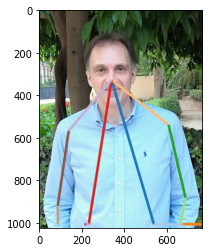

In [24]:
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

def drawline(draw, z, f, t, c):
    if f in z and t in z:
        draw.line((z[f][0], z[f][1], z[t][0], z[t][1]), fill=tuple(c), width=12)
        
def gen_colors():
    arr = plt.cm.tab20(np.linspace(0, 1, 20))
    arr=arr*255
    return arr.astype(int)
    
def draw_stickman(img, json_str):
    draw = ImageDraw.Draw(img)
    data = json.loads(json_str)
    z = data[0]
    colors = gen_colors()
    drawline(draw, z, 'left_hip', 'nose', colors[0])
    drawline(draw, z, 'left_hip', 'left_knee', colors[1])
    drawline(draw, z, 'left_knee', 'left_ankle', colors[2])
    drawline(draw, z, 'left_shoulder', 'nose', colors[3])
    drawline(draw, z, 'left_shoulder', 'left_elbow', colors[4])
    drawline(draw, z, 'left_elbow', 'left_wrist', colors[5])
    drawline(draw, z, 'right_hip', 'nose', colors[6])
    drawline(draw, z, 'right_hip', 'right_knee', colors[7])
    drawline(draw, z, 'right_knee', 'right_ankle', colors[8])
    drawline(draw, z, 'right_shoulder', 'nose', colors[9])
    drawline(draw, z, 'right_shoulder', 'right_elbow', colors[10])
    drawline(draw, z, 'right_elbow', 'right_wrist', colors[11])
    plt.imshow(img)
    plt.show()

draw_stickman(img, json_keypoints)